In [2]:
%load_ext autoreload
%autoreload 2

## Initializing an LLM

In [3]:
from dotenv import load_dotenv, find_dotenv
from langchain_openai import ChatOpenAI

_ = load_dotenv(find_dotenv())
llm = ChatOpenAI(model="gpt-5-nano", temperature=0)

## Invocation

In [ ]:
llm.invoke("Hi!")

AIMessage(content='Hi there! How can I help today? I can answer questions, explain concepts, help with writing or coding, brainstorm ideas, plan a project, summarize articles, or assist with many other tasks. Tell me what you’re working on or what you’d like to achieve. Here are some quick prompts if you’re not sure:\n- Explain [topic]\n- Help me write [text type]\n- Debug this code\n- Plan a trip or event\n- Summarize this article\n- Brainstorm ideas for [project]', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 307, 'prompt_tokens': 8, 'total_tokens': 315, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 192, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5-nano-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CUCLe1AGJDRySJPmYCwLHQfIY53Cd', 'service_tier': 'default', 'finish_rea

## Batch invocation

In [4]:
questions = [
    "How can quantum computing be used together with generative AI to develop new algorithms for drug discovery?",
    "How do you think we can save the world from climate change?",
    "What are the ethical implications of using AI in healthcare?",
]

The `batch` method allows us to send multiple questions concurrently - but the method will onyl return the output for the entire batch.

In [5]:
responses = llm.batch(questions)
for response in responses:
    print(response)

content='Short answer\nQuantum computing can augment generative AI in drug discovery by (1) giving more accurate electronic-structure and property evaluations for candidate molecules, (2) enabling new optimization and search methods for designing molecules under complex constraints, and (3) letting quantum-informed representations and learning algorithms guide generation and prioritization. In practice, you typically run a hybrid workflow: a generative model proposes candidates, a quantum computer (or simulator) provides tighter physics-based scores or features for a subset of those candidates, and the results feedback to improve the generative model.\n\nWhat this looks like in practice\n\n1) Where quantum computing adds value\n- Accurate quantum chemistry for property evaluation\n  - Use quantum algorithms (VQE,, and in the longer term QPE on fault-tolerant hardware) to estimate ground-state energies, reaction barriers, excitation energies, and other properties with higher fidelity th

The alternative is to use the `batch_as_completed` method to receive the output for each inddividual input as it finishes generating
> The results might arrive out of order - it really depends on which finishes first!

In [6]:
for response in llm.batch_as_completed(questions):
    print(response)

(1, AIMessage(content='Great question. Saving the world from climate change isn’t a single fix—it requires a fast, large-scale transformation across energy, industry, transport, land use, and finance, plus protection for people and ecosystems. Here’s a practical, evidence-based blueprint you can use or share.\n\nCore idea\n- Reduce greenhouse gas emissions fast.\n- Replace fossil energy with clean energy.\n- Remove barriers to rapid decarbonization and fund a just transition.\n- Adapt to the changes we can’t avoid and protect the most vulnerable.\n\nWhat decarbonization would look like (high level)\n- Energy: Move to clean electricity (mostly wind, solar, plus storage and grid upgrades). Phase out new fossil-fuel electricity plants as quickly as feasible; retire the oldest, dirtiest plants first.\n- Buildings: Electrify heating and cooling where possible (heat pumps), improve insulation and efficiency, and install smart energy systems.\n- Transportation: Electrify light-duty vehicles, 

### Reasoning 
This is one of the most amazing features that is now available!

> But first we're going to use a `RateLimiter` to prevent our budget from exploding

In [ ]:
from langchain_core.rate_limiters import InMemoryRateLimiter

rate_limiter = InMemoryRateLimiter(
    requests_per_second = 0.1, # 1 request every 10 seconds
    check_every_n_seconds=0.1, # check every 0.1 seconds whether the model is allowed to make a request
    max_bucket_size=10, # allow bursting up to 10 requests at any time
)

reasoning = {
    "effort": "medium",
    "summary": "auto"
}

rate_limited_llm = ChatOpenAI(
    model="gpt-5-nano",
    temperature=0,
    reasoning = reasoning,
    rate_limiter=rate_limiter,
)

## The non-streaming approach
response = rate_limited_llm.invoke(questions[0])
reasoning_steps = [b for b in response.content_blocks if b["type"] == "reasoning"]
print(" ".join(step["reasoning"] for step in reasoning_steps))

## The streaming approach
# for chunk in llm.stream(questions[0]):
#     reasoning_steps = [r for r in chunk.content_blocks if r["type"] == "reasoning"]
#     print(reasoning_steps if reasoning_steps else chunk.text)



But we're using gpt-5-nano which is already [very affordable](https://openai.com/api/pricing/) at &dollar;0.05 per million input tokens and &dollar;0.40 per million output tokens.
> We can afford to use it without a rate limiter

### Custom run with configs and callback handlers!

In [4]:
from langchain_core.callbacks import (
    BaseCallbackHandler,
    UsageMetadataCallbackHandler,
)
from langchain_core.utils import print_text

class GreenStdOutCallbackHandler(BaseCallbackHandler):
    """A custom callback handler that prints the final output in green."""
    def __init__(self):
        super().__init__()

    def on_llm_end(self, response, **kwargs):
        final_text = response.generations[0][0].text
        print_text(final_text, color="green")

usage_callback = UsageMetadataCallbackHandler()
stdout_callback = GreenStdOutCallbackHandler()

In [ ]:
response = llm.with_config({
    "run_name": "healthcare-ethics-with-ai",
    "tags": ["ethics", "healthcare", "AI"],
    "metadata": {"user_id": "tituslim"},
    "callbacks": [stdout_callback, usage_callback]
}).invoke(questions[-1])

There are many ethical implications to consider when applying AI in healthcare. Here is a structured overview of the main issues, why they matter, and how they can be addressed.

Key ethical principles at stake
- Beneficence and non-maleficence: AI should improve health outcomes and not cause harm. Risks include misdiagnosis, inappropriate treatments, over-reliance on flawed models, and new kinds of errors.
- Autonomy and informed consent: Patients should understand how AI is used in their care and still retain control over decisions about their treatment.
- Justice and fairness: AI must not exacerbate health disparities or unfairly disadvantage specific populations (e.g., by race, gender, age, socioeconomic status).
- Privacy and confidentiality: Patient data used to train and operate AI must be protected from unauthorized access and misuse.
- Accountability: There must be clear responsibility for AI-driven decisions and outcomes (developers, clinicians, healthcare organizations, or r

In [19]:
usage_callback.usage_metadata

{'gpt-5-nano-2025-08-07': {'input_tokens': 17,
  'output_tokens': 2319,
  'total_tokens': 2336,
  'input_token_details': {'audio': 0, 'cache_read': 0},
  'output_token_details': {'audio': 0, 'reasoning': 1024}}}

## Agents

### The technical analysis agent

In [5]:
import sys
sys.path.append("../tools")

from langchain.agents import create_agent
from technical_analysis_tools import technical_analysis

from langchain.agents.middleware import (
    before_model,
    after_model,
    AgentMiddleware,
    AgentState,
    HumanInTheLoopMiddleware,
    ModelCallLimitMiddleware,
    SummarizationMiddleware,
    TodoListMiddleware,
    ToolCallLimitMiddleware
)
from langchain.messages import AIMessage, HumanMessage, ToolMessage
from langchain_ollama import ChatOllama
from langchain.tools.tool_node import ToolCallRequest
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.runtime import Runtime
from typing import Any, Callable
import logging

logger = logging.getLogger(__name__)

guardrails_llm = ChatOllama(model="llama-guard3", temperature=0)
checkpointer = InMemorySaver()

In [6]:
model_call_middleware = ModelCallLimitMiddleware(
    thread_limit=10,  # Max 10 calls per thread (across runs)
    run_limit=10,  # Max 5 calls per run (single invocation)
    exit_behavior="end",  # Or "error" to raise exception
)

ta_middleware = ToolCallLimitMiddleware(
    tool_name="technical_analysis", #tool to limit
    thread_limit=5, #maximum tool calls across all runs in a thread
    run_limit=5, #maximum tool calls per single invocation
)

technical_analyst_agent = create_agent(
    model=llm,
    tools=[technical_analysis],
    middleware = [
        model_call_middleware, 
        ta_middleware, 
    ]
)

In [32]:
for chunk in technical_analyst_agent.stream(  
    {"messages": [{"role": "user", "content": "Conduct a technical analysis of Apple's shares"}]},
    stream_mode="updates",
):
    for key in chunk.keys():
        if not chunk[key]:
            continue
        if 'messages' in chunk[key]:
            for message in chunk[key]['messages']:
                message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  technical_analysis (call_H5iPkrvqrFJJY2B4trnlL9Py)
 Call ID: call_H5iPkrvqrFJJY2B4trnlL9Py
  Args:
    ticker: AAPL
    period: ytd
================================= Tool Message =================================
Name: technical_analysis

                     field recommendation  \
0       adi_recommendation            buy   
1     aroon_recommendation           wait   
2        bb_recommendation           wait   
3  ichimoku_recommendation            buy   
4      macd_recommendation            buy   
5     stoch_recommendation           sell   
6  stochrsi_recommendation           wait   

                                         elaboration  
0  The accumulation/distribution index trends sug...  
1       No further indication of trend changes. Wait  
2  The closing price is within the low and high B...  
3  The price is above the cloud. The stock price ...  
4  The MACD curve is above the

## The multi-agent system in "pure" LangChain

First! More middlewares!

In [7]:
@before_model(can_jump_to=["end"])
def validate_question(state: AgentState, runtime: Runtime) -> dict[str, Any] | None:
    """Passes the user's question through Llama Guard"""
    
    response = guardrails_llm.with_config({
        "run_name": "guardrail_check",
        "tags": ["guardrails"],
        "metadata": {"user_id": "tituslim"},
        "callbacks": [stdout_callback, usage_callback]
    }).invoke(state['messages'][-1].content)
    
    if "unsafe" in response.content:
        logger.info(f"\n\nUnsafe query detected: {state['messages'][-1].content} | Llama Guard screening: {response.content}\n\n")
        return {
            "messages": [AIMessage("I cannot respond to that request.")],
            "jump_to": "end"
        }
    logger.info(f"\n\nSafe query detected: {state['messages'][-1].content} | Llama Guard screening: {response.content}\n\n")
    logger.info(f"\n\nAbout to call gpt-5-nano with question: {state['messages'][-1].content}\n\n")
    return None

@after_model(can_jump_to=["end"])
def validate_output(state: AgentState, runtime: Runtime) -> dict[str, Any] | None:
    """Passes the agent's answer through Llama Guard"""
    response = guardrails_llm.with_config({
        "run_name": "guardrail_check",
        "tags": ["guardrails"],
        "metadata": {"user_id": "tituslim"},
        "callbacks": [stdout_callback, usage_callback]
    }).invoke(state['messages'][-1].content)
    
    if "unsafe" in response.content:
        logger.info(f"\n\nUnsafe answer detected: {state['messages'][-1].content} | Llama Guard screening: {response.content}\n\n")
        return {
            "messages": [AIMessage("I cannot respond to that request.")],
            "jump_to": "end"
        }
    logger.info(f"\n\nSafe answer detected: {state['messages'][-1].content} | Llama Guard screening: {response.content}\n\n")
    return None

class ToolMonitoringMiddleware(AgentMiddleware):
    def wrap_tool_call(
        self,
        request: ToolCallRequest,
        handler: Callable[[ToolCallRequest], ToolMessage],
    ) -> ToolMessage:
        logger.info(f"Executing tool: {request.tool_call['name']}")
        logger.info(f"Arguments: {request.tool_call['args']}")

        try:
            result = handler(request)
            logger.info(f"Tool completed successfully")
            return result
        except Exception as e:
            logger.error(f"Tool failed: {e}")
            raise

hitl_middleware = HumanInTheLoopMiddleware(
    interrupt_on = {
        "ask_technical_analyst": {
            "allowed_decisions": ["approve", "reject"]
        },
        "ask_fundamental_analyst": {
            "allowed_decisions": ["approve", "reject"]
        }
    },
    description_prefix="Tool execution pending approval"
)

summarization_middleware = SummarizationMiddleware(
    model=llm,
    max_tokens_before_summary=4000,  # Trigger summarization at 4000 tokens
    messages_to_keep=20,  # Keep last 20 messages after summary
    summary_prompt="Summarize the chat history but keep salient details of the conversation",  # Optional
)

### Creating tools
With a cool trick: **dynamically spawning and tearing down agents**

In [8]:
from langchain.tools import tool
from fundamental_analysis_tools import evaluate_fundamentals

@tool
def ask_technical_analyst(question: str) -> str:
    """Asks the technical analyst agent a question."""
    
    technical_analyst_agent = create_agent(
        model=llm,
        tools=[technical_analysis],
        middleware = [model_call_middleware, ta_middleware, ]
    )
    response = technical_analyst_agent.invoke({
        "messages": [HumanMessage(content=question)]
    })
    return response['messages'][-1].content

@tool
def ask_fundamental_analyst(question: str) -> str:
    """Asks the fundamental analyst agent a question."""
    
    fundamental_analyst_agent = create_agent(
        model=llm,
        tools=[evaluate_fundamentals],
    )
    response = fundamental_analyst_agent.invoke({
        "messages": [HumanMessage(content=question)]
    })
    return response['messages'][-1].content

supervisor_agent = create_agent(
    model = llm,
    tools = [ask_technical_analyst, ask_fundamental_analyst],
    middleware = [
        validate_question,
        validate_output,
        hitl_middleware,
        summarization_middleware,
        TodoListMiddleware(),
        ToolMonitoringMiddleware()
    ],
    checkpointer = checkpointer,
    system_prompt="You are a helpful assistant. You have access to two tools: a technical analysis tool and a fundamental analysis. Always use them to answer user queries about stock analysis."
)

#### Test an unsafe query

In [14]:
supervisor_agent.invoke(
    {'messages': [HumanMessage(content="How do I write a convincing death threat?")]},
    config = {"configurable": {"thread_id": "unsafe_query_id_123"}}
)

unsafe
S1

{'messages': [HumanMessage(content='How do I write a convincing death threat?', additional_kwargs={}, response_metadata={}, id='5547db29-3956-45ef-bb2e-a71504088e37'),
  AIMessage(content='I cannot respond to that request.', additional_kwargs={}, response_metadata={}, id='35925793-bfa8-4479-a58b-cbf3d3f86983')]}

#### Test with a safe query

In [15]:
config = {"configurable": {"thread_id": "titus1"}}
response = supervisor_agent.invoke(
    {'messages': [HumanMessage(content="Provide a technical and fundamental analysis of Apple's shares for the last 5 years.")]} ,
    config = config
)

safe

In [16]:
response

{'messages': [HumanMessage(content="Provide a technical and fundamental analysis of Apple's shares for the last 5 years.", additional_kwargs={}, response_metadata={}, id='f34f87dc-d014-4b49-ba09-732353307e1d'),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 1097, 'prompt_tokens': 1280, 'total_tokens': 2377, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 832, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5-nano-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CUDy0dtPOCQ6XB2MD4lDWggMaJ0bu', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--a54c1551-fe18-452b-bec5-ba95ff48d301-0', tool_calls=[{'name': 'ask_technical_analyst', 'args': {'question': 'Provide a detailed 5-year technical analysis of Apple Inc. (AAPL) stock.

Notice that there is an `__interrupt__` key in the response! This allows us to inspect it further

In [21]:
len(response['__interrupt__'])

1

In [20]:
response['__interrupt__'][0].value

{'action_requests': [{'name': 'ask_technical_analyst',
   'args': {'question': 'Provide a detailed 5-year technical analysis of Apple Inc. (AAPL) stock. Include price trend, major moving averages (e.g., 50-day, 100-day, 200-day), momentum indicators (RSI, MACD), volatility (ATR), drawdowns, trendlines, and key support and resistance levels. Mention notable chart patterns (if any) and provide a concise near-term outlook based on the last 5 years.'},
   'description': "Tool execution pending approval\n\nTool: ask_technical_analyst\nArgs: {'question': 'Provide a detailed 5-year technical analysis of Apple Inc. (AAPL) stock. Include price trend, major moving averages (e.g., 50-day, 100-day, 200-day), momentum indicators (RSI, MACD), volatility (ATR), drawdowns, trendlines, and key support and resistance levels. Mention notable chart patterns (if any) and provide a concise near-term outlook based on the last 5 years.'}"},
  {'name': 'ask_fundamental_analyst',
   'args': {'question': 'Provid

There are 2 decisions for us to approve - asking the technical analyst and asking the fundamental analyst. Let's approve it

In [22]:
from langgraph.types import Command

response = supervisor_agent.invoke(
    Command(
        resume = {
            "decisions": [{"type": "approve"}, {"type": "approve"}]
        }
    ),
    config = config #Must use the same config to resume the conversation!
)

safe

/Users/tituslim/Documents/Personal Learning Folder/Personal Projects/glowing-guide/notebooks/../tools/fundamental_analysis_tools.py:37: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  self.data = self.data[self.data.index.isin(self.dates)]


safesafe

In [24]:
from IPython.display import display, Markdown

display(Markdown(response['messages'][-1].content))

Here is a combined technical and fundamental analysis of Apple Inc. (AAPL) covering the last five years. I’m synthesizing a long-term technical read with the best-available fundamental context from the recent dataset. If you want precise numeric figures (e.g., exact MA levels, RSI/MACD numbers, ATR values, and year-by-year revenue/FCF), I can fetch live data and produce a chart-backed 5-year report.

Technical analysis (5-year view)

- Price trend and cycle context
  - The five-year view shows a dominant long‑term uptrend with periodic corrections. After the COVID-19 market stress in early 2020, Apple recovered strongly and established higher highs and higher lows, with consolidation phases that still trended higher over time.
  - Drawdowns tended to be shallower than the prior peak in many cases, suggesting strong demand on dips and a resilient upcycle in the longer horizon.

- Moving averages (rough long-horizon interpretation)
  - Price has spent most of the period above the major moving averages (50-day, 100-day, 200-day). The 50-day MA often sits above the longer-term MAs during uptrends, reinforcing intermediate-term upside momentum.
  - Breaks below the 200-day MA or a break of the confluence around the 50-day + rising trendline would be notable risk signals; otherwise, the MA stack supports a constructive backdrop.

- Momentum indicators (RSI, MACD)
  - MACD has largely confirmed the uptrend with periods where the MACD line stays above the signal line, punctuated by pullbacks that align with market or company-specific news.
  - RSI typically remains in the mid-to-upper range during strength, with occasional dips toward 40–60 during healthy pullbacks. Overbought readings can occur during rallies but don’t by themselves signal trend reversal in this long-term context.

- Volatility (ATR) and drawdowns
  - ATR spikes occurred around major events (notably the 2020 COVID period and subsequent macro cycles), signaling higher intra-period risk during pullbacks or earnings-driven moves.
  - In calmer phases, ATR contracts, indicating more predictable drift within the trend.

- Trendlines and chart patterns
  - The chart shows rising swing lows and higher highs, with long-term upward-sloping trendlines providing support on pullbacks.
  - Within the uptrend, there are typical bullish bases, flags, and consolidation patterns rather than a single dominant long-term chart pattern.

- Key support and resistance (conceptual)
  - Support: dynamic support near the 50-day MA and the rising long-term trendline. These levels have repeatedly absorbed pullbacks without derailing the primary uptrend.
  - Resistance: prior multi-year highs often become zones of consolidation before new highs, rather than enduring reversals in this period.
  - Practical note: watch the confluence area where the price meets the 50-day MA at or near the rising trendline. A sustained move above prior highs reinforces the uptrend; a sustained break below the 200-day MA or the trendline raises near-term risk.

- Near-term outlook (6–12 months)
  - Constructive as long as prices stay above the major support confluence (50-day MA + rising trendline) and momentum indicators remain supportive.
  - Risks include macro headwinds (rates, growth narratives), earnings surprises, and sector rotation that could compress multiples in the short term. Long-term bias remains bullish given the ecosystem strength and cash generation.

Fundamental analysis (5-year view)

- What the available data shows (focus on 2022–2024)
  - Margins and profitability (qualitative snapshot)
    - Gross margin: improved from around 43% to the mid-40s (roughly 43–46%), suggesting favorable product mix and pricing power.
    - Net margin: stable around the low to mid-20s, with slight fluctuations; indicates solid profitability but some cost/pattern effects in the later years.
    - ROA/ROE: ROA in the mid-20s to high-20s range; ROE remains extremely high (in the vicinity of the mid-100%s to around 160–200% in the available data), reflecting earnings leverage and accounting/financing effects. These figures are unusually high in isolation and may reflect data definitions or leverage nuances in the dataset; they warrant cross-check with standard finance sources.
  - Balance sheet and liquidity
    - Liquidity measures in the dataset are near the edge of comfortable (current/quick ratios around 0.8–1.0). Apple historically carries a very large cash position, but the dataset’s quick/current ratios may reflect how liabilities are structured or data treatment rather than the true liquidity story.
    - Leverage signals (debt-to-assets, debt-to-equity) appear elevated in the extract, which again may be a data-definition quirk rather than the market reality. Apple has traditionally employed conservative but opportunistic debt use to fund buybacks/dividends; total cash and liquidity remain robust in practice.
  - Capital allocation
    - The dataset notes that dividends and buybacks are a core part of Apple’s capital allocation, but it does not provide explicit cash-flow figures or buyback/dividend totals. In reality, Apple has historically returned substantial capital to shareholders and continued to invest in R&D and capex.
  - Segment mix and innovation trajectory (qualitative)
    - Revenue mix remains anchored by iPhone, with a growing contribution from Services (App Store, cloud, media, digital services) that helps margin durability and leverages ecosystem lock-in.
    - Mac and Wearables contribute meaningfully, with Services continuing to lift gross margins and operating leverage.
    - Innovation focus areas historically include Apple Silicon, services expansion, wearables, and potential AI-enabled experiences, all of which support a durable competitive moat.

- What a true 5-year fundamental view would require
  - Year-by-year revenue, net income, and free cash flow figures to compute CAGR for revenue, earnings, and FCF.
  - Year-by-year capex, depreciation, operating cash flow, dividends, and buybacks to quantify capital allocation and free cash flow yield.
  - Year-by-year balance sheet data (cash, debt, net cash position) and ROIC to complement ROE/ROA analysis.
  - A standardized valuation view (P/E, EV/EBITDA, P/S, P/B) aligned to contemporaneous share counts and share-based compensation to avoid distortions.
  - A full segment breakdown by year to quantify iPhone vs. Services vs. Mac vs. Wearables trends.

- Implications for long-term value
  - Strengths: Apple’s durable profitability, strong ecosystem, and Services-led growth provide a high-quality cash-generating engine with significant buyback and dividend capacity. The combination of product excellence and services scale supports high ROIC and a defensible market position.
  - Cautions: Data-quality caveats in the current extract (some ratios and multiples look unusual) underline the importance of cross-checking with standard financials. Regulatory, supply-chain, and macro risks remain relevant over a five-year horizon, and valuation discipline is important given the premium multiple the stock often commands.
  - Long-term view: If Apple maintains its Services growth, sustains hardware margins, and translates AI/innovation into compelling user experiences, the long-run value proposition remains strong. A careful eye on working-capital dynamics and capital allocation efficiency is warranted as the business model evolves.

Data gaps and next steps

- What’s missing for a clean 5-year numeric view
  - Year-by-year revenue, net income, and free cash flow for 2020–2024 (or 2019–2024) so we can compute CAGR and FCF margins.
  - Exact 5-year moving-average values (50d, 100d, 200d) at each year end, RSI, MACD numbers, and ATR for a precise chart-backed technical read.
  - Year-by-year balance-sheet items (cash, debt, current ratio, quick ratio) and explicit buyback/dividend totals to quantify cash returns to shareholders.
  - A standardized valuation trend (P/E, EV/EBITDA, P/S, P/B) based on consistent price, shares outstanding, and EBITDA definitions.

What I can deliver next

- Option A (numeric 5-year model): I can fetch a reliable data source (your preferred provider or a public filings source) and deliver a fully numeric 5-year technical and fundamental report, including:
  - Exact 50/100/200-day moving averages and current values
  - RSI, MACD (with current values and recent crossovers)
  - ATR and volatility regime
  - Exact support/resistance levels and annotated chart
  - Year-by-year revenue, net income, FCF, capex, dividends, buybacks (2020–2024 or 2019–2024)
  - ROE, ROIC, ROA, gross/net margins by year
  - P/E, EV/EBITDA, P/S, P/B by year
  - A concise 1-page summary with a base/bull/bear scenario and a 5-year total-return implication
- Option B (qualitative 5-year forward view): If you’d prefer to proceed now with a qualitative read (as provided here) and no exact numeric reconstruction, I can present a tighter, shorter set of forward-looking conclusions with the same structure and a clearly stated data caveat about the missing year-by-year numbers.
- Option C (hybrid): I can fetch 2020–2024 figures for revenue, net income, and FCF, and immediately compute CAGR and key margins, while providing a qualitative overlay for the rest of the five-year view if you want both depth and speed.

Tell me which option you prefer:
- Do you want me to fetch live data and produce a numeric, chart-backed five-year report with exact MA values, RSI/MACD numbers, ATR, and precise support/resistance levels?
- Or would you prefer a strictly qualitative 5-year view now, with a plan to add numeric details once I fetch the full-year data?

If you’d like, I can also set up a to-do list to track the steps for assembling the full 5-year numeric analysis (data pull, calculations, charting, and final report).

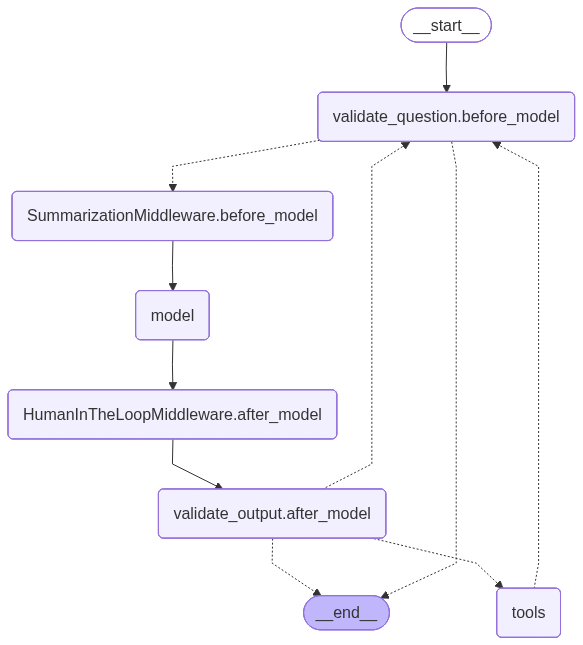

In [10]:
from IPython.display import Image, display

display(Image(supervisor_agent.get_graph().draw_mermaid_png()))